# Text classification using CNN 

### Import module

In [1]:
# modules
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# created own library for dealing with embedding
from utils.embedding import Embeddor

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load movie reviews data

In [2]:
# loading x and y

src = "./data/rt-polaritydata/"
pos_src = src + "rt-polarity.pos"
neg_src = src + "rt-polarity.neg"

with open(pos_src) as f:
    pos_txt = f.readlines()
    y_pos = [1] * len(pos_txt)

with open(neg_src) as f:
    neg_txt = f.readlines()
    y_neg = [0] * len(neg_txt)
    
x_total = np.concatenate((pos_txt, neg_txt))
y_total = np.concatenate((y_pos, y_neg))
n = np.size(x_total)

print("There is %d elements in x" % n)

There is 10662 elements in x


### Load embeddings

In [3]:
%%time

# parameters
n_emb = 100000 * 3
src = "./embeddings"
emb_name = os.listdir(src)[-1]
print("Embedding: %s" % emb_name)
src_emb = os.path.join(src, emb_name)

# embeddor
embeddor = Embeddor(notebook_display=True)
emb_mat = embeddor.load_emb(src_emb, n_emb)
print("Embedding shape: {}".format(emb_mat.shape))

Embedding: fasttext.wiki.en.vec


Widget Javascript not detected.  It may not be installed or enabled properly.



Embedding shape: (300001, 300)
CPU times: user 27.9 s, sys: 2.23 s, total: 30.2 s
Wall time: 27.9 s


### CNN builder functions

In [4]:
# height-wise convolution
def apply_conv1d(x, filter_size, stride, out_size, bias=True, wide=True):
    if wide:
        pad_size = filter_size - 1
        paddings = [[0, 0], [pad_size, pad_size], [0, 0], [0, 0]]
        x = tf.pad(x, paddings=paddings)
    width = x.get_shape().as_list()[2]
    filter_shape = [filter_size, width, 1, out_size]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
    conv = tf.nn.conv2d(x, 
                        W, 
                        strides=[1, stride, 1, 1], 
                        padding='VALID',
                        data_format='NHWC',
                        name='conv1d')
    if bias:
        b = tf.Variable(tf.constant(0.1, shape=[out_size]), name='b')
        conv = tf.nn.bias_add(conv, b)
    return conv

def apply_one_max_pool1d(x):
    height = x.get_shape().as_list()[1]
    return tf.nn.max_pool(x,
                          ksize=[1, height, 1, 1], 
                          strides=[1, 1, 1, 1],
                          padding='VALID', 
                          name='one_max_pool')

def hstack_channels(x):
    shape = x.get_shape().as_list()
    height = shape[1]
    width = shape[-1]
    return tf.reshape(x, 
                      shape=[-1, height, width, 1], 
                      name='stack')

def apply_max_pool1d(x, window=10, stride=1):
    width = x.get_shape().as_list()[2]
    return tf.nn.max_pool(x,
                          ksize=[1, window, width, 1],
                          strides=[1, stride, 1, 1], 
                          padding='VALID',
                          data_format='NHWC',
                          name='max_pool')
    
def apply_flatten(x):
    shape = x.get_shape().as_list()
    out_size = 1
    for dim in shape[1:]:
        out_size *= dim
    return tf.reshape(x, [-1, out_size], name='flatten')

def apply_fully_connected(x, out_size):
    in_size = x.get_shape().as_list()[-1]
    W = tf.Variable(
        tf.truncated_normal(
            [in_size, out_size], stddev=0.1 ),
        name="weights"
    )
    b = tf.Variable(tf.constant(0.1, shape=[out_size]), name="biases")
    return tf.nn.xw_plus_b(x, W, b, name="fully_connected_layer")

### CNN hyper-parameters

In [5]:
emb_mat = embeddor.emb
emb_shape = np.shape(emb_mat)
emb_size = emb_shape[1]
x_seq = embeddor.to_seq(x_total, padding=True)
y_seq = y_total
seq_size = embeddor.pad_dim
filter_size = 7
num_filters = 100
num_classes = 2
trainable=True

### CNN graph architecture

In [6]:
%%time
# reset graph
tf.reset_default_graph()

# placeholders
x_input = tf.placeholder(tf.int32, shape=[None, seq_size], name='x_input')
y_input = tf.placeholder(tf.int64, shape=[None], name='y_input')
e_input = tf.placeholder(tf.float32, shape=emb_shape, name='e_input')
dropout = tf.placeholder(tf.float32, name='dropout_keep_prob')

with tf.device("/cpu:0"):
    
    with tf.name_scope("embedding"):
        E = tf.Variable(tf.constant(0.0, shape=emb_shape), trainable=trainable, name="embedding")
        emb_init = E.assign(e_input)
        emb_seq = tf.nn.embedding_lookup(E, x_input)
        emb_seq_expanded = tf.expand_dims(emb_seq, -1)
        
    with tf.name_scope("conv1"):
        conv = apply_conv1d(emb_seq_expanded, filter_size, 1, 300, bias=True, wide=True)
        h = tf.nn.relu(conv, name='relu')
        h_pool = apply_one_max_pool1d(h)
        h_flat = apply_flatten(h_pool)
        
    with tf.name_scope("dropout1"):
        h_out = tf.nn.dropout(h_flat, dropout)
        
    with tf.name_scope("fc1"):
        scores = apply_fully_connected(h_out, num_classes)
        preds = tf.argmax(scores, 1, name='preds')
        
    with tf.name_scope("loss"):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=scores,
            labels=y_input,
            name='losses')
        loss = tf.reduce_mean(losses, name='loss')

    with tf.name_scope("accuracy"):
        correct_predictions = tf.equal(preds, y_input)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
    
    with tf.name_scope("optimization"):
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss)
        
    init = tf.global_variables_initializer()

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 160 ms


#### Testing specific layer

In [7]:
%%time
with tf.Session() as sess:
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    D = {x_input: x_seq, y_input: y_seq}
    out = sess.run(emb_seq, feed_dict=D)

CPU times: user 561 ms, sys: 567 ms, total: 1.13 s
Wall time: 899 ms


### Training CNN

#### Emptying tensorflow summaries

In [8]:
path = "./tensorflow_summaries"
for file in os.listdir(path):
    filepath = os.path.join(path, file)
    if os.path.isfile(filepath) and file != ".gitkeep":
        os.remove(filepath)

#### Train helper functions

In [9]:
def get_stat(sess, x, y, 
             x_input=x_input, y_input=y_input, dropout=dropout):
    feed_dict={x_input: x, y_input: y, dropout: 1}
    acc, l = sess.run([accuracy, loss], feed_dict=feed_dict)
    return acc, l

def print_acc_loss(acc_train, loss_train, acc_test, loss_test, epoch=-1):
    if  epoch == -1:
        log_string = "init. __    train acc: %0.2f  test acc: %0.2f" % (acc_train, acc_test)
    else:
        log_string = "epoch %2d    train acc: %0.2f  test acc: %0.2f" % (epoch, acc_train, acc_test)
    log_string += "   loss train: %2.2f  loss test: %2.2f" % (loss_train, loss_test)
    print(log_string)

#### Training loop

In [10]:
batch_size = 64
num_epochs = 4
p = 0.5
seed = 10
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, train_size=0.75, random_state=seed)

In [11]:
%%time
with tf.Session() as sess:
    # init
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    train_stat = get_stat(sess, x_train, y_train)
    test_stat = get_stat(sess, x_test, y_test)
    print_acc_loss(*train_stat, *test_stat)
    
    # batch training
    losses = list()
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            batch_xs = x_train[idx: idxn]
            batch_xy = y_train[idx: idxn]
            feed_train = {x_input: batch_xs, y_input: batch_xy, dropout: p}
            __, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)

        train_stat = get_stat(sess, x_train, y_train)
        test_stat = get_stat(sess, x_test, y_test)
        print_acc_loss(*train_stat, *test_stat, e)
        
    # monitoring
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)

init. __    train acc: 0.50  test acc: 0.49   loss train: 0.77  loss test: 0.77
epoch  0    train acc: 0.92  test acc: 0.78   loss train: 0.31  loss test: 0.48
epoch  1    train acc: 0.98  test acc: 0.80   loss train: 0.11  loss test: 0.42
epoch  2    train acc: 0.99  test acc: 0.79   loss train: 0.04  loss test: 0.46
epoch  3    train acc: 1.00  test acc: 0.79   loss train: 0.02  loss test: 0.52
CPU times: user 22min 30s, sys: 4min 13s, total: 26min 44s
Wall time: 1min 53s


#### Training loss

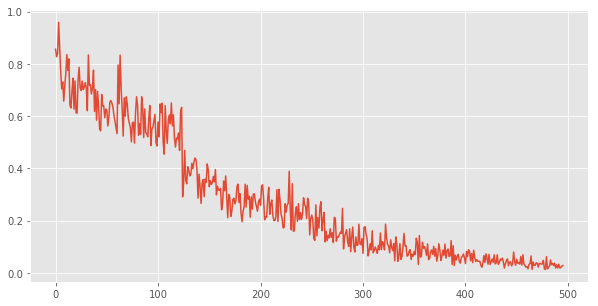

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(losses)

In [13]:
embeddor.most_similar("louis")

[('louis', 0.99999982),
 ('#louis', 0.69709212),
 ('stlouis', 0.57748413),
 ('francois', 0.57693326),
 ('louisy', 0.5757497),
 ('charles', 0.55591291),
 ('missouri–st', 0.55274689),
 ('antoine', 0.543244),
 ('philippe', 0.54233646),
 ('lorimier', 0.5418663)]